In [215]:
import bayes3d as b
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax
import matplotlib.pyplot as plt

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7038/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:

importance_jit = jax.jit(b.model.importance)

contact_enumerators = [b.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]
add_object_jit = jax.jit(b.add_object)

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [244]:
OUTLIER_VOLUME = 1.0
VARIANCE_GRID = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID = jnp.array([0.00001, 0.0001, 0.001])

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


In [6]:
V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

if HIERARCHICAL_BAYES:
    V_GRID = VARIANCE_GRID
    O_GRID = OUTLIER_GRID
else:
    V_GRID, O_GRID = jnp.array([VARIANCE_GRID[V_VARIANT]]), jnp.array([OUTLIER_GRID[O_VARIANT]])

print(V_GRID, O_GRID)

[1.e-04 1.e-03 1.e-02] [1.e-05 1.e-04 1.e-03]


In [7]:
key = jax.random.PRNGKey(502)

In [187]:
camera_pose = b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.4, 0.32]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)

camera_poses = jnp.array([
    b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle) @ camera_pose
    for angle in jnp.linspace(-jnp.pi, jnp.pi, 120)[:-1]]
)

In [234]:
for (i,p) in enumerate(camera_poses):
    b.show_pose(f"{i}", p)

In [235]:
camera_pose_enumerators = b.make_enumerator(["camera_pose"])

In [282]:
w = 0.03
translation_deltas = b.utils.make_translation_grid_enumeration(-w,-w,-w,w,w,w, 13, 13, 13)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf_zero_mean(key, 0.01, 600.0))(
    jax.random.split(jax.random.PRNGKey(3), 500)
)


In [ ]:

def update_pose_estimate(trace):
    proposals = jnp.einsum("ij,ajk->aik", trace["camera_pose"], translation_deltas)
    weights = camera_pose_enumerators[3](trace, key, proposals)
    bool = (weights.max() > trace.get_score())
    current_camera_pose = trace["camera_pose"] * (1.0 - bool) + bool * proposals[jnp.argmax(weights)]
    trace = b.update_address(trace, key,  "camera_pose", current_camera_pose)

    proposals = jnp.einsum("ij,ajk->aik", trace["camera_pose"], rotation_deltas)
    weights = camera_pose_enumerators[3](trace, key, proposals)
    current_camera_pose = trace["camera_pose"] * (1.0 - bool) + bool * proposals[jnp.argmax(weights)]
    trace = b.update_address(trace, key,  "camera_pose", current_camera_pose)
    return trace
update_pose_estimate_jit = jax.jit(update_pose_estimate)

In [283]:
# key = jax.random.split(key, 1)[0]

gt_traces = [importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "parent_3": 0,
    "id_0": jnp.int32(21),
    "camera_pose": p,
    "root_pose_0": jnp.eye(4),
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_parent_3": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "face_child_3": 3,
    "variance": 0.05,
    "outlier_prob": 0.1,
}), (
    jnp.arange(4),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.1, -0.1, -1*jnp.pi]), jnp.array([0.1, 0.1, 1*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
)[1] for p in camera_poses]

In [278]:
viz_images = [b.get_depth_image(i["image"][:,:,2]) for i in gt_traces]
b.make_gif_from_pil_images(viz_images,"sweep.gif")

In [279]:
current_camera_pose = camera_poses[0]

In [284]:
T = 2
gt_pose = gt_traces[T]["camera_pose"]
trace = b.update_address(gt_traces[T], key,  "camera_pose", current_camera_pose)
print(gt_traces[T].get_score())
print(trace.get_score())
b.viz_trace_meshcat(trace)
b.show_pose("gt_pose", gt_traces[T]["camera_pose"], size=0.05)

-22262.994
-22265.682


In [290]:
diff = b.inverse_pose(trace["camera_pose"]) @ gt_traces[T]["camera_pose"]
diff_translation = b.transform_from_pos(diff[:3,3])
diff_translation

Array([[ 1.        ,  0.        ,  0.        ,  0.04216149],
       [ 0.        ,  1.        ,  0.        , -0.00139196],
       [ 0.        ,  0.        ,  1.        ,  0.00173998],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)

In [292]:
weights = camera_pose_enumerators[3](trace, key, jnp.array([trace["camera_pose"] @ diff]))
weights

Array([-22262.994], dtype=float32)

Array([[ 0.9944295 ,  0.06584518, -0.08230648,  0.04216149],
       [-0.06584518,  0.9978262 ,  0.00271733, -0.00139196],
       [ 0.08230647,  0.00271728,  0.9966033 ,  0.00173998],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)

In [ ]:
trace = b.update_address(trace, key,  "camera_pose", current_camera_pose)
print(trace.get_score())

In [285]:
for _ in range(50):
    print(trace.get_score())
    trace = update_pose_estimate_jit(trace)
    b.show_pose("gt_pose", gt_traces[T]["camera_pose"], size=0.05)
    b.show_pose("estimated_pose", trace["camera_pose"], size=0.07)
print(trace.get_score())


-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682
-22265.682


In [230]:
proposals = jnp.einsum("ij,ajk->aik", trace["camera_pose"], translation_deltas)
weights = camera_pose_enumerators[3](trace, key, proposals)
bool = (weights.max() > trace.get_score())
current_camera_pose = trace["camera_pose"] * (1.0 - bool) + bool * proposals[jnp.argmax(weights)]
trace = b.update_address(trace, key,  "camera_pose", current_camera_pose)

In [223]:
weights.max()

Array(-8194.48, dtype=float32)

In [220]:
for (i,p) in enumerate(proposals):
    b.show_pose(f"{i}", p)

In [221]:
b.clear()

-19044.816
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75
-19019.75


In [103]:
current_camera_pose = trace["camera_pose"] @ b.transform_from_pos(jnp.array([0.05, 0.0, 0.0]))
trace = b.update_address(trace, key,  "camera_pose", current_camera_pose)
print(trace.get_score())

-47257.945


In [86]:
gt_traces[T]["camera_pose"] @ b.inverse_pose(trace["camera_pose"])

Array([[ 9.9657857e-01, -7.0071176e-02,  4.3821458e-02, -1.0093506e-01],
       [ 6.9971003e-02,  9.9754184e-01,  3.8154454e-03, -1.5127361e-03],
       [-4.3981113e-02, -7.3627965e-04,  9.9903208e-01, -6.2564313e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)

In [34]:
proposals = jnp.einsum("ij,ajk->aik", trace["camera_pose"], rotation_deltas)
weights = camera_pose_enumerators[3](trace, key, proposals)
print(weights.shape)
current_camera_pose = proposals[jnp.argmax(weights)]
trace = b.update_address(trace, key,  "camera_pose", current_camera_pose)
print(trace.get_score())
b.viz_trace_meshcat(trace)
b.show_pose("gt_pose", gt_traces[T]["camera_pose"], size=0.05)

(500,)
-11775.629


In [23]:
current_camera_pose - gt_traces[T]["camera_pose"]

Array([[ 0.00233889,  0.00313512,  0.0745003 , -0.03639003],
       [-0.05618222, -0.00209159,  0.00285894, -0.01466182],
       [ 0.0489638 ,  0.00190574, -0.00046027,  0.01042596],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

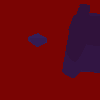

In [49]:
b.get_depth_image(camera_pose_enumerator(gt_trace, key, camera_poses[10])["image"][:,:,2])

In [ ]:
# import imageio
# images = [imageio.imread(f'mug_results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(50))]
# imageio.mimsave("mug_results.gif", images, 'GIF', duration=1200)

In [31]:
T = 1
new_image = b.update_address(trace, "camera_pose", 

In [11]:

OBJECT_INDEX = 2
print(f"Searching for object index {OBJECT_INDEX} {b.utils.ycb_loader.MODEL_NAMES[OBJECT_INDEX]}")

Searching for object index 2 004_sugar_box


In [ ]:
bounds = 1.5
grid = b.utils.make_translation_grid_enumeration_3d(
    -bounds, -bounds, -0.0,
    bounds, bounds, 0.0,
    50,50,1
)

[21 16 14  0]
Searching for object index 0 002_master_chef_can


In [58]:
_,trace = importance_jit(key, gt_trace.get_choices(), (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:]))

path = []
obj_id = OBJECT_INDEX
trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
number = b.get_contact_params(trace_).shape[0] - 1
path.append(trace_)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace_ = c2f_contact_update_jit(trace_, key, number,
        contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
    path.append(trace_)

b.viz_trace_meshcat(trace_)

In [30]:
b.viz_trace_meshcat(trace_)

In [29]:
all_all_paths = []
for _ in range(3):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
        path = []
        trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
        number = b.get_contact_params(trace_).shape[0] - 1
        path.append(trace_)
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            trace_ = c2f_contact_update_jit(trace_, key, number,
                contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
            path.append(trace_)
        # for c2f_iter in range(len(contact_param_gridding_schedule)):
        #     trace_ = c2f_contact_update_jit(trace_, key, number,
        #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        all_paths.append(
            path
        )
    all_all_paths.append(all_paths)
    
    scores = jnp.array([t[-1].get_score() for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    trace = all_paths[jnp.argmax(scores)][-1]
    b.viz_trace_meshcat(trace)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.71it/s]


[ 2548.6626 14774.171   7377.7397 -3475.9414  5269.176  -7196.0664
 -5233.695  -6695.6104 -2148.8408 -3450.3425  8947.765   9300.127
 -5743.9297 -2807.3076 -1425.6399 11404.119  -6352.1636 -7689.706
 -3784.6074 -3113.241  -5834.1514]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.62it/s]


[15061.046 14754.643 15116.449 15996.487 15639.642 17100.955 17266.04
 17223.559 16054.247 19141.137 12930.077 14737.587 16521.13  16645.545
 19558.793 14594.951 18172.09  17861.113 17879.781 18135.814 17305.645]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:13<00:00,  1.55it/s]

[19543.145 19538.926 19543.42  19543.145 19545.879 21622.791 21416.744
 21984.324 19543.146 23906.627 17714.36  19370.07  19543.146 19543.146
 20890.385 19379.234 22955.54  22645.396 22401.283 21512.049 21582.82 ]


In [30]:
print(b.get_indices(gt_trace))
print(b.get_indices(trace))

[21 14  9  1]
[21  1 14  9]
